## Design of Experiments to optimize perovskite solar cells efficiency
Version 1.0.0
(c) Vincent M. Le Corre, Larry Lueer, i-MEET 2021-2023

This notebook is made to use BOAR to design experiments. Here, we show how to load some data from a presampling, and how to use BOAR to suggest the next set of experiment using Bayesian optimization.
The goal here is to optimize the processing conditions for a perovskite solar cell to maximize the power conversion efficiency (PCE).

Note: The data used here is real data generated in the [i-MEET](https://www.i-meet.ww.uni-erlangen.de/) and [HI-ERN](https://www.hi-ern.de/de) labs at the university of Erlangen-Nuremberg (FAU) by Jiyun Zang. The data is not published yet, and is only used here for demonstration purposes. For more information, please contact us.

In [1]:
# Activate matplotlib widgets
# %matplotlib inline
# comment the next line if you are on the jupyterhub server
# %matplotlib widget 
# %matplotlib notebook
import plotly.io as pio # comment out to only render png
pio.renderers.default = 'png'

# Import libraries
import sys,os,types,copy
import warnings
import pandas as pd
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar
sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *
from boar.core.optimization_botorch import *
# import additional libraries from Ax
from ax.utils.notebook.plotting import render, init_notebook_plotting # for plotting in notebook
from ax.plot.slice import plot_slice
from ax.plot.scatter import interact_fitted,plot_objective_vs_constraints,tile_fitted
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.contour import interact_contour
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier
# Import homemade package by VLC
# import boar.SIMsalabim_utils.plot_settings_screen # to set default plot settings



In [2]:
# Define the path to the data 
curr_dir = os.getcwd() # current directory
res_dir = os.path.join(os.path.abspath('../'),'temp') # path to the results directory
data_dir = os.path.join(os.path.abspath('../'),'Example_Data') 

In [3]:
names =['No.', 'Spin_Speed_1', 'Duration_t1', 'Spin_Speed_2', 'Dispense_Speed','Duration_t3', 'Pmax']
df = pd.read_excel(os.path.join(data_dir,'Jiyun','Inital Data Set LHS + Devices Results.xlsx'),'First Round',skiprows=[0,2],usecols=[0,3,4,5,6,7,17],names=names)
df = df.dropna()
df = df.reset_index(drop=True)

# print stats on the data
print(df.describe())



             No.  Spin_Speed_1  Duration_t1  Spin_Speed_2  Dispense_Speed  \
count  32.000000     32.000000    32.000000     32.000000       32.000000   
mean   16.500000   1500.784375    21.568438   1997.100625      204.753750   
std     9.380832    583.231977     7.935312    587.607149      114.860663   
min     1.000000    540.030000     8.580000   1021.640000       16.030000   
25%     8.750000   1007.037500    15.107500   1513.842500      107.287500   
50%    16.500000   1487.390000    21.350000   1985.235000      208.160000   
75%    24.250000   1988.642500    28.302500   2488.645000      294.430000   
max    32.000000   2471.680000    34.340000   2993.560000      396.430000   

       Duration_t3       Pmax  
count    32.000000  32.000000  
mean     17.492812  15.980469  
std       7.267707   3.871971  
min       5.550000   4.690000  
25%      11.432500  14.939000  
50%      17.435000  17.266000  
75%      23.390000  18.562750  
max      29.390000  19.824000  


In [4]:
params_names = names[1:-1]
target_names = [names[-1]]
df_filtered = copy.deepcopy(df[params_names+target_names])
df_filtered = df_filtered.drop_duplicates()
df_filtered = df_filtered.dropna()


dic = {'x':[],'y_0':[],'ydyn_0':1,'y_1':[],'ydyn_1':1}
for num in range(len(df_filtered)):
    dic['x'].append(df_filtered[params_names].iloc[num].values.tolist())
    dic['y_0'].append(df_filtered[target_names[0]].iloc[num])
    

# save to res_dir
with open(os.path.join(res_dir,'old_XY.json'), 'w') as fp:
    json.dump(dic, fp)

print(dic)

{'x': [[2404.3, 15.37, 1745.24, 203.73, 13.43], [1835.67, 17.26, 2289.07, 289.2, 11.71], [1067.9, 33.77, 2352.58, 235.32, 5.55], [2276.03, 18.09, 1821.08, 26.02, 15.74], [2147.06, 30.31, 2816.31, 290.32, 29.06], [1152.66, 28.88, 2734.96, 122.63, 8.57], [1240.99, 23.85, 2993.56, 190.72, 19.98], [2471.68, 21.86, 1394.98, 138.38, 29.39], [907.4, 9.36, 2766.28, 314.87, 22.86], [2034.13, 18.67, 1021.64, 90.9, 7.89], [540.03, 19.25, 2383.83, 16.03, 23.23], [1532.37, 12.86, 1955.23, 383.93, 18.06], [1024.8, 8.58, 2631.08, 367.72, 21.69], [1768.01, 22.92, 2927.6, 77.78, 10.6], [1598.13, 29.16, 2592.42, 396.43, 23.87], [691.46, 14.32, 1661.51, 248.43, 19.54], [1745.39, 28.11, 1098.41, 108.1, 16.43], [2111.73, 31.26, 2065.44, 349.36, 27.79], [621.02, 26.31, 1221.45, 51.78, 26.15], [1442.41, 9.97, 1297.14, 306.76, 9.05], [810.2, 33.24, 1776.59, 258.82, 6.39], [1308.04, 32.43, 2558.77, 146.55, 12.7], [1333.17, 20.49, 1878.83, 212.59, 24.7], [863.48, 34.34, 1535.26, 104.85, 25.37], [675.45, 26.72, 

# Define the free parameters to be optimized

In [5]:
params = []

Spin_Speed_1 = Fitparam(name = 'Spin_Speed_1', val =  1000, lims = [500, 3000], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Spin Speed 1', unit = 'RPM',val_type='int',rescale=False)
params.append(Spin_Speed_1)
Duration_t1 = Fitparam(name = 'Duration_t1', val =  10, lims = [5, 35], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Duration t1', unit = 's',val_type='int'
                        ,rescale=False)
params.append(Duration_t1)
Spin_Speed_2 = Fitparam(name = 'Spin_Speed_2', val =  1000, lims = [1000, 3000], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Spin Speed 2', unit = 'RPM',val_type='int'
                        ,rescale=False)
params.append(Spin_Speed_2)
Dispense_Speed = Fitparam(name = 'Dispense_Speed', val =  100, lims = [10, 400], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Dispense Speed', unit = '',val_type='int'
                        ,rescale=False)
params.append(Dispense_Speed)
Duration_t3 = Fitparam(name = 'Duration_t3', val =  10, lims = [5, 35], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Duration t3', unit = 's',val_type='int'
                        ,rescale=False)
params.append(Duration_t3)

In [6]:
# create an excel file with len(params) columns and nb_new_exp rows filled with nan
nb_new_exp = 18
dat_array = np.zeros((nb_new_exp, len(params))).tolist()
# replace all with 'nan'
for i in range(len(dat_array)):
    for j in range(len(dat_array[i])):
        dat_array[i][j] = 'nan'
pnames = [ p.name for p in params ]
df = pd.DataFrame(dat_array, columns=pnames)
df.to_excel(os.path.join(res_dir,'BOAR_Exp.xlsx'), index=False)

df2 = pd.read_excel(os.path.join(res_dir,'BOAR_Exp.xlsx'))
print(df2)
def exp_to_df(X,params):
    pass

    Spin_Speed_1  Duration_t1  Spin_Speed_2  Dispense_Speed  Duration_t3
0            NaN          NaN           NaN             NaN          NaN
1            NaN          NaN           NaN             NaN          NaN
2            NaN          NaN           NaN             NaN          NaN
3            NaN          NaN           NaN             NaN          NaN
4            NaN          NaN           NaN             NaN          NaN
5            NaN          NaN           NaN             NaN          NaN
6            NaN          NaN           NaN             NaN          NaN
7            NaN          NaN           NaN             NaN          NaN
8            NaN          NaN           NaN             NaN          NaN
9            NaN          NaN           NaN             NaN          NaN
10           NaN          NaN           NaN             NaN          NaN
11           NaN          NaN           NaN             NaN          NaN
12           NaN          NaN           NaN        

# Start the optimization

In [7]:
# Define the targets and the model for the TM problem
X_dimensions = ['_']
y_dimension = 'Pmax'
target = {'model':exp_to_df,'target_name':'Pmax','minimize':False,
          'data':{'X':[0],'y':[0],'X_dimensions':X_dimensions,'X_units':['V',''],'y_dimension':y_dimension,'y_unit':'mW cm$^{-2}$'}
            ,'target_weight':1, 'weight':1}


targets = [target]
obj_type='identity'
loss='linear'
threshold=[18]

mo = MooBOtorch(params=params, targets= targets) # initialize the optimization object
mo.warmstart = 'recall'
mo.parallel = False # needed if number of cores is lower than number of CPU - 1 to ensure we output the right number of points
# mo.SaveOldXY2file = os.path.join(res_dir,'old_XY.json')
mo.Path2OldXY = os.path.join(res_dir,'old_XY.json')
# mo.parameter_constraints = [f'{stepsize_fraction}*Cs_fraction + {stepsize_fraction}*Fa_fraction <= 1']

# Define custom evaluation function
def evaluate_custom(self,px,obj_type,loss,threshold=1,is_MOO=True):
  pass
  

mo.evaluate_custom = types.MethodType(evaluate_custom, mo) # add the method to the object FullyBayesianMOO
kwargs_posterior = {'Nres':10,'Ninteg':1e3,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'True_values':None,'show_points':True,'savefig':False,'figname':'param_posterior','full_grid':True,'randomize':True}

ax_client = mo.BoTorchOpti(n_jobs=[nb_new_exp], n_step_points = [nb_new_exp], models=['GPEI'],obj_type=obj_type,loss=loss,threshold=threshold,use_CUDA=True,is_MOO=False,verbose=True,show_posterior=False,kwargs_posterior=kwargs_posterior,use_custom_func=True,suggest_only=True)

[INFO 09-20 09:41:56] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 09-20 09:41:56] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='Spin_Speed_1', parameter_type=INT, range=[500, 3000]), RangeParameter(name='Duration_t1', parameter_type=INT, range=[5, 35]), RangeParameter(name='Spin_Speed_2', parameter_type=INT, range=[1000, 3000]), RangeParameter(name='Dispense_Speed', parameter_type=INT, range=[10, 400]), RangeParameter(name='Duration_t3', parameter_type=INT, range=[5, 35])], parameter_constraints=[]).
[INFO 09-20 09:41:56] ax.core.experiment: Attached custom parameterizations [{'Spin_Speed_1': 2404, 'Duration_t1': 15, 'Spin_Speed_2': 1745, 'Dispense_Speed': 203, 'Duration_t3': 13}] as trial 0.
[INFO 09-20 09:41:56] ax.service.ax_client: Completed trial 0 with data: {'identit

In [8]:
# Print the optimized stack structure
for p in mo.params:
    if p.val_type != 'str':
        print(p.display_name + f' {p.val:.0f} ')
        print(p.lims)
    else:
        print(p.display_name + f' {p.val}')

Spin Speed 1 1333 
[500, 3000]
Duration t1 20 
[5, 35]
Spin Speed 2 1878 
[1000, 3000]
Dispense Speed 212 
[10, 400]
Duration t3 24 
[5, 35]


In [9]:
# get all tried data from the ax_client
triedX = ax_client.generation_strategy.trials_as_df
# print(triedX.tail())
triedY = ax_client.experiment.fetch_data().df
# print(triedY.tail())

# find Trial Status ABANDONED
abandoned_trials = triedX[triedX['Trial Status']=='ABANDONED']
dics = []
for index, row in abandoned_trials.iterrows():
    
    dic_dum = abandoned_trials['Arm Parameterizations'][index]
    key = list(dic_dum.keys())[0]
    dic = dic_dum[key]
    dics.append(dic)

# put in a dataframe
df2try = pd.DataFrame(dics)

# save to excel
df2try.to_excel(os.path.join(res_dir,'BOAR_Exp_2_try.xlsx'), index=False)

    

[INFO 09-20 09:42:36] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


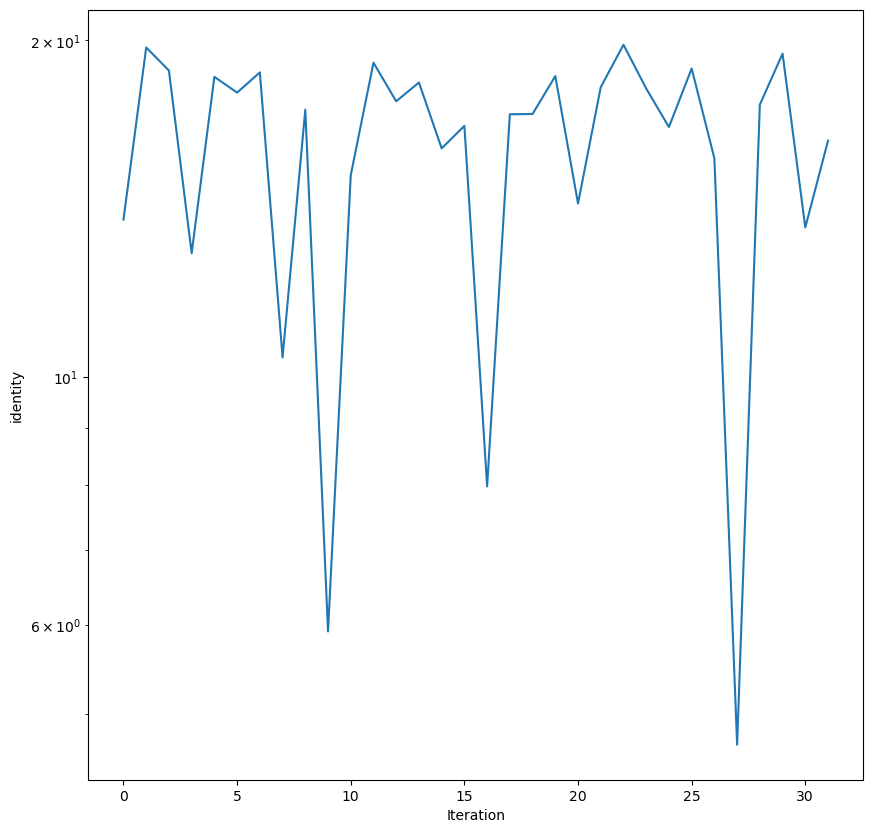

In [10]:
# Plot the Pareto front of the test problem
mo.plot_all_objectives(ax_client,logscale=True,figsize=(10,10))

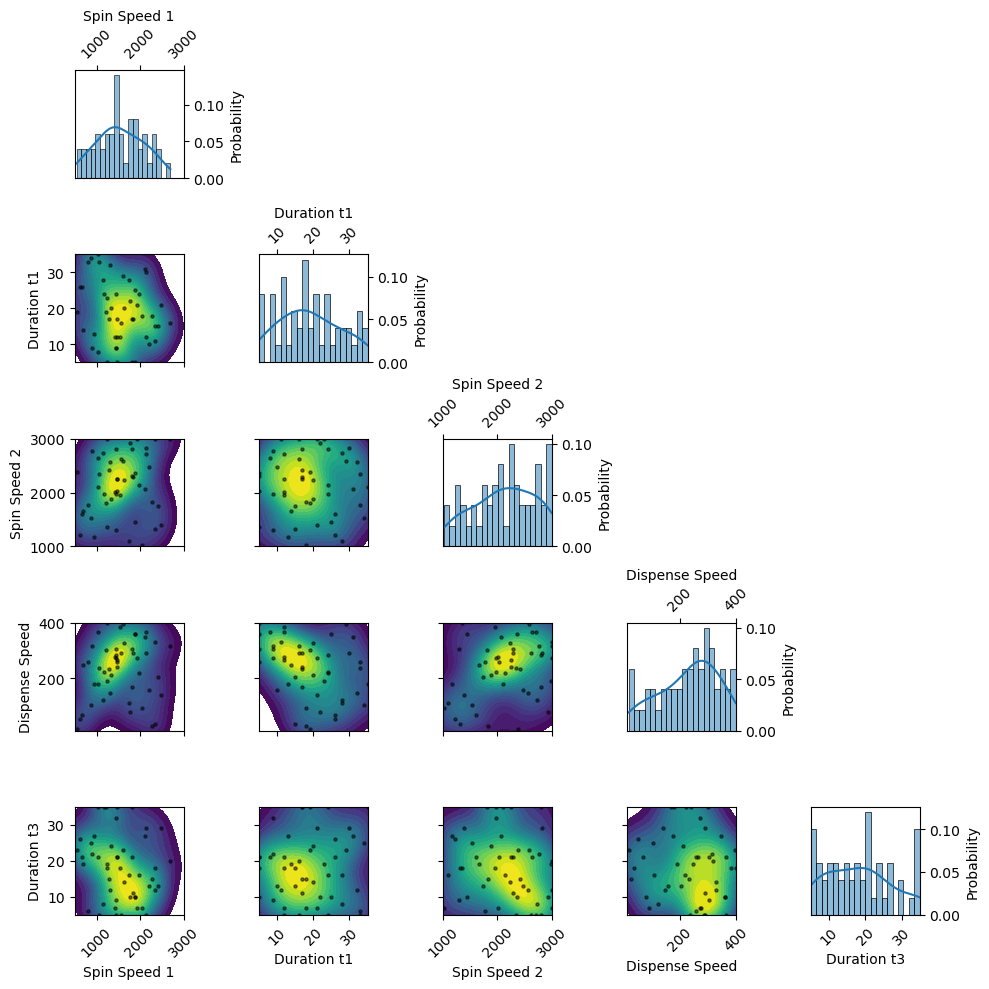

In [11]:
# Plot the density of points that were sampled during the optimization process
mo.plot_density(ax_client,figsize=(10,10))

[INFO 09-20 09:42:38] ax.service.ax_client: Retrieving contour plot with parameter 'Spin_Speed_1' on X-axis and 'Duration_t3' on Y-axis, for metric 'identity'. Remaining parameters are affixed to the middle of their range.


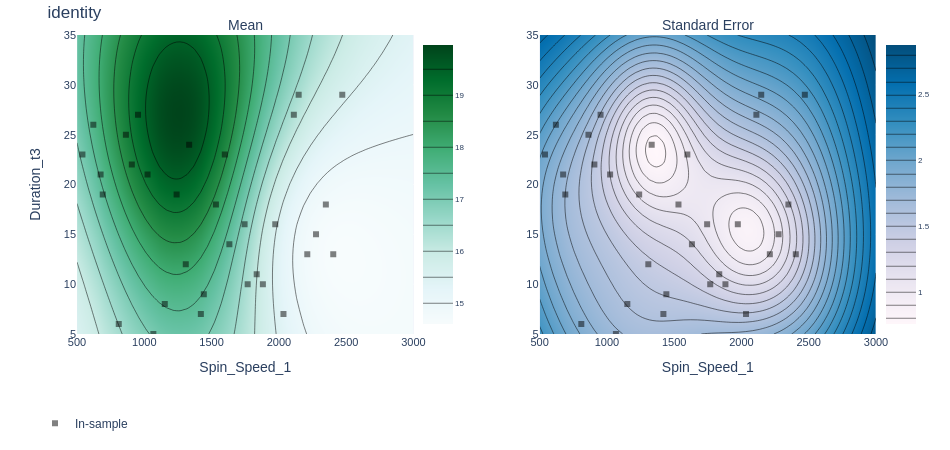

[INFO 09-20 09:42:39] ax.service.ax_client: Retrieving contour plot with parameter 'Spin_Speed_1' on X-axis and 'Duration_t1' on Y-axis, for metric 'identity'. Remaining parameters are affixed to the middle of their range.


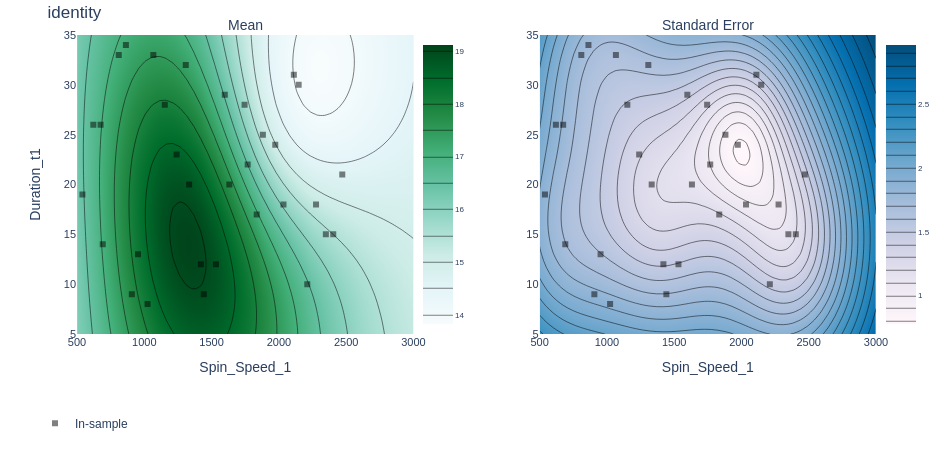

[INFO 09-20 09:42:40] ax.service.ax_client: Retrieving contour plot with parameter 'Spin_Speed_1' on X-axis and 'Dispense_Speed' on Y-axis, for metric 'identity'. Remaining parameters are affixed to the middle of their range.


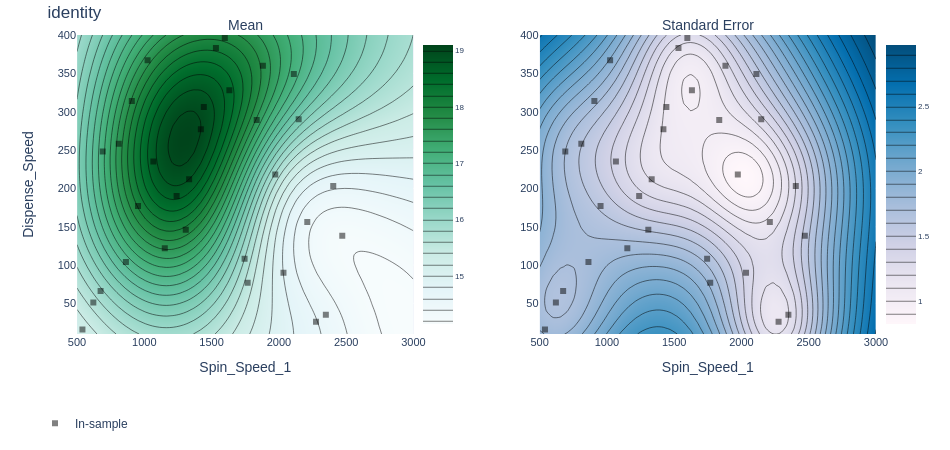

In [12]:
# Plot the contour of the objective function for a given target

render(ax_client.get_contour_plot(param_x=params[0].name, param_y=params[-1].name, metric_name=obj_type))
render(ax_client.get_contour_plot(param_x=params[0].name, param_y=params[1].name, metric_name=obj_type))
render(ax_client.get_contour_plot(param_x=params[0].name, param_y=params[-2].name, metric_name=obj_type))



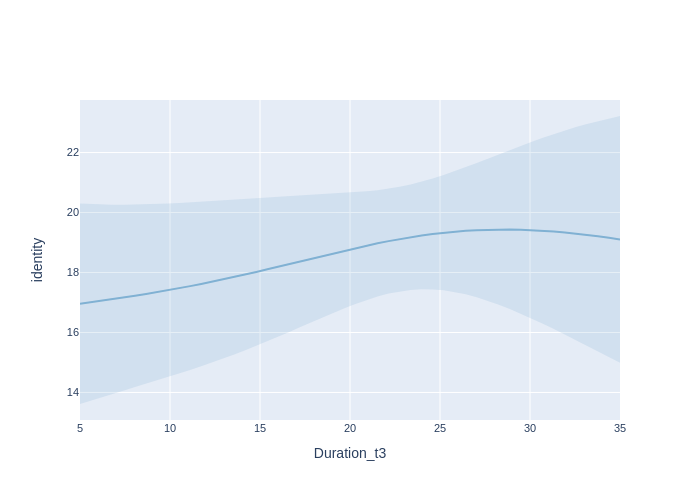

In [13]:
# Plot the slice (i.e., 1D projection) of the model along the a single dimension 
model = ax_client.generation_strategy.model
render(plot_slice(model, params[-1].name, obj_type))



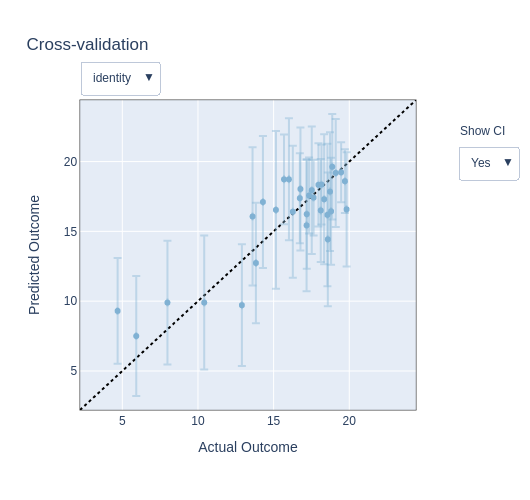

In [14]:
# Plot the results of cross validation
cv_results = cross_validate(model)
render(interact_cross_validation(cv_results))

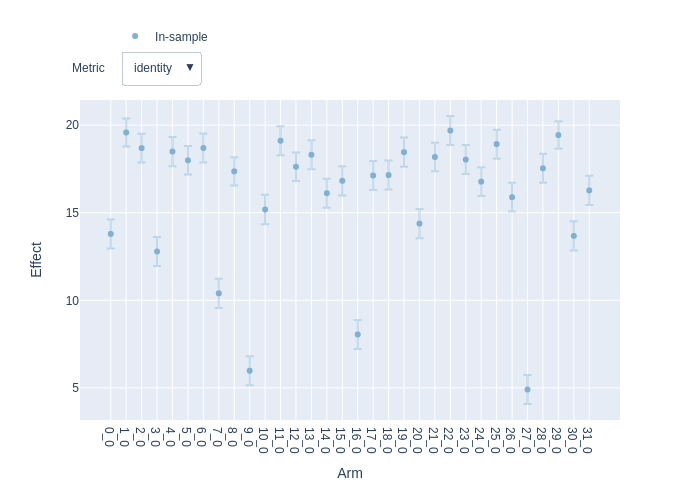

In [15]:
# Interactive plot of the target during the optimization process
render(interact_fitted(model, rel=False))